# Installs/Imports

In [1]:
%pip install -q ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 26.2 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 84.0 MB/s eta 0:00:00:00:0100:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import glob
import random
import yaml
import shutil
from shutil import copyfile
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import jensenshannon
import time

import IPython.display as display
from PIL import Image
import cv2

import ultralytics
from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [3]:
ultralytics.checks()

Ultralytics 8.3.146 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Setup complete ✅ (4 CPUs, 31.4 GB RAM, 6361.9/8062.4 GB disk)


In [5]:
class Config:
    DEBUG = False
    FRACTION = 0.05 if DEBUG else 1.0
    SEED = 42

    TARGET_RATIOS = {'train': 0.80, 'valid': 0.15, 'test': 0.05}


    PPE_CLASSES = {
        0: "Hardhat",
        1: "Mask",
        2: "NO-Hardhat",
        3: "NO-Mask",
        4: "NO-Safety Vest",
        5: "Person",
        6: "Safety Cone",
        7: "Safety Vest",
        8: "Machinery",
        9: "Vehicle"
    }

    EPOCHS = 3 if DEBUG else 30 
    BATCH_SIZE = 16
    IMGSZ = 640  
    RECT = False 
    VERBOSE = False 
    SHOW_LABELS = False 
    SHOW_CONF = False 
    SHOW_BOXES = False 
    BASE_MODEL = 'yolo11n.pt' 
    DEVICE = "cuda"

    CSS_DATA_PATH = '../input/construction-site-safety-image-dataset-roboflow/css-data'
    OUTPUT_PATH = './'
    WORKING_PATH = "../working/"
    FOLDERS = ["train", "valid", "test"]

    TRAIN_RESULTS = f"{WORKING_PATH}/train_results.csv"
    MODEL_PATH = f'{WORKING_PATH}/runs/detect/train/weights/best.pt'
    OUTPUT_MODEL_PATH = f'{WORKING_PATH}/best.pt'
    METADATA_PATH = f'{WORKING_PATH}/metadata.json'

In [31]:
model = YOLO(Config.BASE_MODEL) 

100%|██████████| 5.35M/5.35M [00:00<00:00, 69.4MB/s]


# Create YAML file

In [32]:
def save_yaml_file(dataset_yaml, dataset_config):
    with open(dataset_yaml, "w") as f:
        yaml.dump(dataset_config, f, default_flow_style=False)
    
    print(f"✅ Dataset YAML file saved at: {dataset_yaml}")

def read_yaml_file(file_path):
    with open(file_path, 'r') as file:
        try:
            data = yaml.safe_load(file)
            return data
        except yaml.YAMLError as e:
            print("Error reading YAML:", e)
            return None

def print_yaml_data(data):
    formatted_yaml = yaml.dump(data, default_style=False)
    print(formatted_yaml)

In [33]:
dataset_yaml = os.path.join(Config.WORKING_PATH, "dataset.yaml")

dataset_config = {
    "path": Config.WORKING_PATH, 
    "train": "train/images", 
    "val": "valid/images",  
    "test": "test/images",  
    "nc": len(Config.PPE_CLASSES), 
    "names": list(Config.PPE_CLASSES.values()), 
}

In [34]:
save_yaml_file(dataset_yaml, dataset_config)

✅ Dataset YAML file saved at: /kaggle/working/dataset.yaml


In [35]:
yaml_data = read_yaml_file(dataset_yaml)

if yaml_data:
    print_yaml_data(yaml_data)

names:
- Hardhat
- Mask
- NO-Hardhat
- NO-Mask
- NO-Safety Vest
- Person
- Safety Cone
- Safety Vest
- Machinery
- Vehicle
nc: 10
path: /kaggle/working/
test: test/images
train: train/images
val: valid/images



# Train

In [36]:
train_data = {
    "epochs": Config.EPOCHS,
    "batch": Config.BATCH_SIZE,
    "imgsz": Config.IMGSZ,
    "rect": Config.RECT,
    "fraction": Config.FRACTION,
    "seed": Config.SEED,
    "verbose": Config.VERBOSE,
    "show_labels": Config.SHOW_LABELS,
    "show_conf": Config.SHOW_CONF,
    "show_boxes": Config.SHOW_BOXES,
    "device": Config.DEVICE
}

In [37]:
start_time = time.time()

train_results = model.train(
    data=dataset_yaml,
    **train_data
)

end_time = time.time()
training_duration = end_time - start_time  

Ultralytics 8.3.146 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/dataset.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, p

100%|██████████| 755k/755k [00:00<00:00, 20.1MB/s]


Overriding model.yaml nc=80 with nc=10

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      6640  ultralytics.nn.modules.block.C3k2            [32, 64, 1, False, 0.25]      
  3                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
  4                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  5                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  6                  -1  1     87040  ultralytics.nn.modules.block.C3k2            [128, 128, 1, True]           
  7                  -1  1    295424  ultralytic

train: Scanning /kaggle/working/train/labels... 2904 images, 17 backgrounds, 0 corrupt: 100%|██████████| 2904/2904 [00:02<00:00, 1444.27it/s]

train: /kaggle/working/train/images/construction-813-_jpg.rf.b085952261fd98f2e76b8065de149b5f.jpg: 1 duplicate labels removed


train: New cache created: /kaggle/working/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 364.7±63.1 MB/s, size: 52.9 KB)


val: Scanning /kaggle/working/valid/labels... 420 images, 6 backgrounds, 0 corrupt: 100%|██████████| 420/420 [00:00<00:00, 811.25it/s] 

val: /kaggle/working/valid/images/004720_jpg.rf.afc486560a4004c7cfd67910af31a29c.jpg: 1 duplicate labels removed
val: New cache created: /kaggle/working/valid/labels.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/train
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.78G       1.51      3.314      1.585        183        640: 100%|██████████| 182/182 [00:42<00:00,  4.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  3.00it/s]

                   all        420       5739      0.442        0.3      0.268      0.141



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      3.14G      1.468      2.204      1.577        141        640: 100%|██████████| 182/182 [00:40<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.99it/s]

                   all        420       5739      0.493       0.38      0.374      0.193



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      3.16G      1.422      1.996      1.548        201        640: 100%|██████████| 182/182 [00:39<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  4.69it/s]

                   all        420       5739      0.547      0.393      0.413      0.217



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      3.18G      1.396      1.902      1.528        137        640: 100%|██████████| 182/182 [00:39<00:00,  4.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.35it/s]

                   all        420       5739       0.63      0.431      0.468      0.257



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      3.19G      1.366      1.846      1.505        164        640: 100%|██████████| 182/182 [00:39<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.50it/s]

                   all        420       5739      0.644      0.446      0.487      0.268



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      3.21G      1.349      1.805      1.488        144        640: 100%|██████████| 182/182 [00:39<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.52it/s]

                   all        420       5739      0.662      0.463      0.507      0.278



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      3.22G      1.301      1.698      1.459        202        640: 100%|██████████| 182/182 [00:39<00:00,  4.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  4.69it/s]

                   all        420       5739      0.691       0.47      0.522      0.294



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      3.23G      1.304      1.669      1.447        227        640: 100%|██████████| 182/182 [00:39<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.32it/s]

                   all        420       5739      0.677      0.507      0.554      0.319



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      3.25G      1.273      1.628      1.429        119        640: 100%|██████████| 182/182 [00:39<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.60it/s]

                   all        420       5739       0.74      0.499      0.573      0.333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      3.27G       1.26      1.583      1.413        177        640: 100%|██████████| 182/182 [00:39<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  4.84it/s]

                   all        420       5739      0.706      0.503      0.561       0.32



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      3.28G      1.247      1.556      1.408        123        640: 100%|██████████| 182/182 [00:39<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  4.82it/s]

                   all        420       5739      0.711      0.523      0.577       0.33



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      3.29G      1.239       1.53      1.399        159        640: 100%|██████████| 182/182 [00:39<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  4.95it/s]

                   all        420       5739      0.736      0.531      0.593      0.357



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      3.31G       1.23      1.515      1.391        118        640: 100%|██████████| 182/182 [00:39<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  4.88it/s]

                   all        420       5739      0.743      0.545       0.61      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      3.32G       1.21      1.455      1.371        178        640: 100%|██████████| 182/182 [00:39<00:00,  4.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  4.77it/s]

                   all        420       5739      0.726      0.537      0.596      0.335



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      3.34G      1.187      1.426      1.358        184        640: 100%|██████████| 182/182 [00:39<00:00,  4.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  4.67it/s]

                   all        420       5739      0.776      0.554      0.629      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      3.35G      1.183       1.42      1.359        154        640: 100%|██████████| 182/182 [00:39<00:00,  4.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  4.82it/s]

                   all        420       5739      0.764      0.582      0.638      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      3.36G      1.173      1.388      1.344        191        640: 100%|██████████| 182/182 [00:39<00:00,  4.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  4.99it/s]

                   all        420       5739      0.783      0.574      0.647      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      3.38G      1.145      1.361      1.335        144        640: 100%|██████████| 182/182 [00:39<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  4.85it/s]

                   all        420       5739      0.777       0.59       0.65      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30       3.4G      1.147      1.354      1.332        173        640: 100%|██████████| 182/182 [00:39<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  4.93it/s]

                   all        420       5739      0.798      0.588      0.659      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      3.41G      1.138      1.323      1.321        140        640: 100%|██████████| 182/182 [00:39<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.01it/s]

                   all        420       5739      0.795      0.592      0.661      0.412


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      3.42G      1.181      1.305      1.355         94        640: 100%|██████████| 182/182 [00:39<00:00,  4.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  4.83it/s]

                   all        420       5739      0.811      0.596      0.671      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      3.44G      1.152      1.238      1.339        149        640: 100%|██████████| 182/182 [00:38<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.01it/s]

                   all        420       5739      0.811      0.609      0.681      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      3.45G       1.14      1.222      1.325        156        640: 100%|██████████| 182/182 [00:38<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  4.91it/s]

                   all        420       5739       0.81      0.614      0.683      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      3.47G      1.117      1.188       1.31         84        640: 100%|██████████| 182/182 [00:38<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  4.84it/s]

                   all        420       5739       0.83      0.611      0.688      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      3.48G      1.108      1.176      1.306         93        640: 100%|██████████| 182/182 [00:38<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.02it/s]

                   all        420       5739      0.825       0.62       0.69       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30       3.5G      1.097      1.162      1.297        139        640: 100%|██████████| 182/182 [00:38<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  4.89it/s]

                   all        420       5739      0.836       0.63      0.706      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      3.51G      1.082      1.132      1.285         91        640: 100%|██████████| 182/182 [00:38<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  4.98it/s]

                   all        420       5739      0.837      0.634      0.704      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      3.53G      1.062      1.113      1.273        106        640: 100%|██████████| 182/182 [00:38<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  4.94it/s]

                   all        420       5739      0.838      0.637      0.706      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      3.54G      1.053      1.103      1.267         63        640: 100%|██████████| 182/182 [00:38<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  4.95it/s]

                   all        420       5739      0.835      0.635       0.71      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      3.56G      1.045      1.086      1.263         94        640: 100%|██████████| 182/182 [00:38<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.03it/s]

                   all        420       5739      0.833      0.641      0.714      0.473



30 epochs completed in 0.358 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 5.5MB
Optimizer stripped from runs/detect/train/weights/best.pt, 5.5MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLO11n summary (fused): 100 layers, 2,584,102 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.54it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        420       5739      0.834       0.64      0.713      0.473
Speed: 0.2ms preprocess, 3.3ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs/detect/train


In [38]:
train_metrics = {
    "train_id": f"train_{pd.Timestamp.now().strftime('%Y%m%d_%H%M%S')}",  # Unique ID
    "model": Config.BASE_MODEL,  # Model used
    "mAP50": train_results.box.map50,
    "mAP50-95": train_results.box.map,
    "Precision": train_results.box.mp,
    "Recall": train_results.box.mr,
    "train_time": round(training_duration, 2)  
}

In [39]:
print("\n📊 Final Training Metrics:")
for metric, value in train_metrics.items():
    if isinstance(value, (int, float)):  
        print(f"   {metric}: {value:.3f}")
    else:
        print(f"   {metric}: {value}")  


📊 Final Training Metrics:
   train_id: train_20250528_185133
   model: yolo11n.pt
   mAP50: 0.713
   mAP50-95: 0.473
   Precision: 0.834
   Recall: 0.640
   train_time: 1316.910


In [40]:
train_summary = {**train_metrics, **train_data}

train_df = pd.DataFrame([train_summary])

In [74]:
if os.path.exists(Config.TRAIN_RESULTS):
    existing_df = pd.read_csv(Config.TRAIN_RESULTS)
    updated_df = pd.concat([existing_df, train_df], ignore_index=True)
else:
    updated_df = train_df

updated_df.to_csv(Config.TRAIN_RESULTS, index=False)

print(f"Training results saved successfully")

Training results saved successfully


In [42]:
train_df = pd.read_csv(Config.TRAIN_RESULTS)

In [43]:
pd.set_option("display.width", 200)  
pd.set_option("display.max_columns", None)  

In [44]:
print(train_df)

                train_id       model     mAP50  mAP50-95  Precision    Recall  train_time  epochs  batch  imgsz   rect  fraction  seed  verbose  show_labels  show_conf  show_boxes device
0  train_20250528_185133  yolo11n.pt  0.713328  0.473285   0.833661  0.640259     1316.91      30     16    640  False       1.0    42    False        False      False       False   cuda


# Saving the model as a Dataset

In [75]:
metadata = {
    "model": "YOLO11s",
    "description": "Trained YOLO11 (yolo11n.pt) model on PPE detection dataset",
    "source": "Construction Site PPE detection w/ YOLO v11 notebook",
}
with open(Config.METADATA_PATH, "w") as f:
    json.dump(metadata, f)

print(f"Model saved")

Model saved


# Validation

In [66]:
import pandas as pd

val_results = model.val(data=dataset_yaml, split='val', verbose=True)

overall_metrics = {
    "Dataset": ["val"],
    "Precision": [val_results.box.mp],       # mean precision across classes
    "Recall": [val_results.box.mr],          # mean recall across classes
    "mAP50": [val_results.box.map50],        # mean mAP@0.5
    "mAP50-95": [val_results.box.map]        # mean mAP@0.5:0.95
}

# Create DataFrame
df_overall = pd.DataFrame(overall_metrics)

# Calculate F1 Score
df_overall["F1 Score"] = 2 * (df_overall["Precision"] * df_overall["Recall"]) / (
    df_overall["Precision"] + df_overall["Recall"] + 1e-6
)

# Display
print(df_overall)


Ultralytics 8.3.146 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1122.9±268.8 MB/s, size: 45.9 KB)


val: Scanning /kaggle/working/valid/labels.cache... 420 images, 6 backgrounds, 0 corrupt: 100%|██████████| 420/420 [00:00<?, ?it/s]

val: /kaggle/working/valid/images/004720_jpg.rf.afc486560a4004c7cfd67910af31a29c.jpg: 1 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:06<00:00,  4.37it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        420       5739      0.832      0.641      0.714      0.474
               Hardhat        202        536      0.883      0.604      0.717      0.422
                  Mask        169        246      0.936       0.85      0.898       0.67
            NO-Hardhat        199        315       0.79      0.599      0.646      0.391
               NO-Mask        230        480      0.777      0.425      0.509      0.239
        NO-Safety Vest        261        576      0.816      0.672      0.732       0.47
                Person        392       1432      0.834      0.727      0.801      0.582
           Safety Cone        120        651      0.831      0.458      0.584      0.288
           Safety Vest        194        451      0.867      0.649      0.705      0.476
             Machinery        312        803      0.863      0.823      0.887      0.721
               Vehicle        123        249      0.721      0.606      0.663      0.476
Speed: 0.9ms preproce

In [67]:
import pandas as pd

# Run validation on the validation set
val_results = model.val(data=dataset_yaml, split='test', verbose=True)

# Extract overall metrics
overall_metrics = {
    "Dataset": ["test"],
    "Precision": [val_results.box.mp],       # mean precision across classes
    "Recall": [val_results.box.mr],          # mean recall across classes
    "mAP50": [val_results.box.map50],        # mean mAP@0.5
    "mAP50-95": [val_results.box.map]        # mean mAP@0.5:0.95
}

# Create DataFrame
df_overall = pd.DataFrame(overall_metrics)

# Calculate F1 Score
df_overall["F1 Score"] = 2 * (df_overall["Precision"] * df_overall["Recall"]) / (
    df_overall["Precision"] + df_overall["Recall"] + 1e-6
)

# Display
print(df_overall)


Ultralytics 8.3.146 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1429.1±490.1 MB/s, size: 65.6 KB)


val: Scanning /kaggle/working/test/labels.cache... 140 images, 1 backgrounds, 0 corrupt: 100%|██████████| 140/140 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  2.24it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        140       1959      0.819      0.646      0.711      0.469
               Hardhat         72        167      0.927      0.683      0.774      0.482
                  Mask         51         79       0.88      0.823      0.858      0.582
            NO-Hardhat         68        136       0.78      0.547      0.601      0.362
               NO-Mask         80        159      0.777      0.421      0.511      0.231
        NO-Safety Vest         98        227      0.836       0.63      0.695      0.456
                Person        135        514      0.811      0.714      0.786      0.565
           Safety Cone         28        146      0.849      0.499      0.613      0.311
           Safety Vest         70        156      0.833      0.641      0.709      0.464
             Machinery        116        297      0.828      0.855      0.894       0.72
               Vehicle         42         78      0.669      0.647      0.672      0.513
Speed: 2.1ms preproce

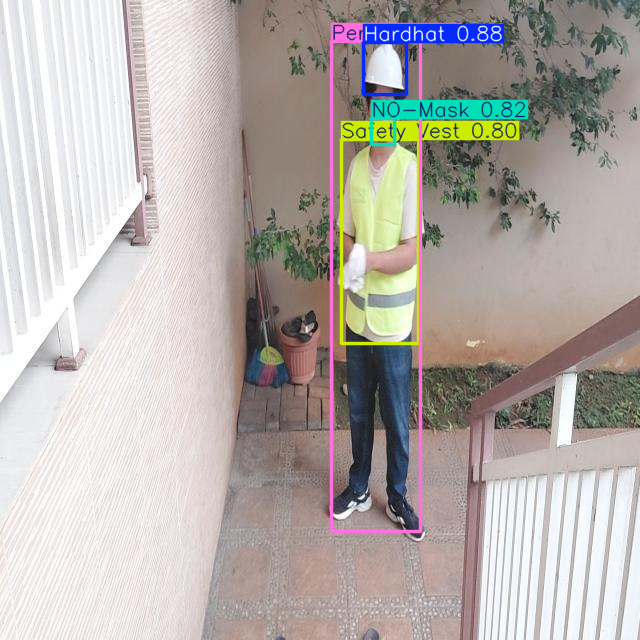

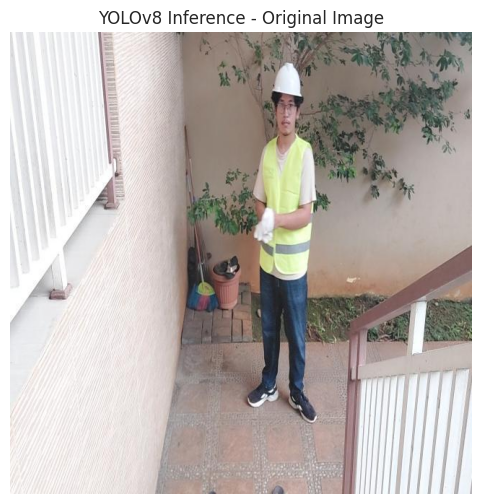

In [54]:
from PIL import Image
import matplotlib.pyplot as plt

# Path to test image
image_path = "../input/ppe-kit-detection-construction-site-workers/data/images/test/image1009.jpg"

# Perform inference
results = model.predict(source=image_path, conf=0.25, show_labels=True, show_conf=True)

# Visualize predictions (uses OpenCV by default)
results[0].show()

# Optionally, you can save and view with matplotlib
img = Image.open(image_path)
plt.figure(figsize=(10, 6))
plt.imshow(img)
plt.title("YOLOv8 Inference - Original Image")
plt.axis("off")
plt.show()


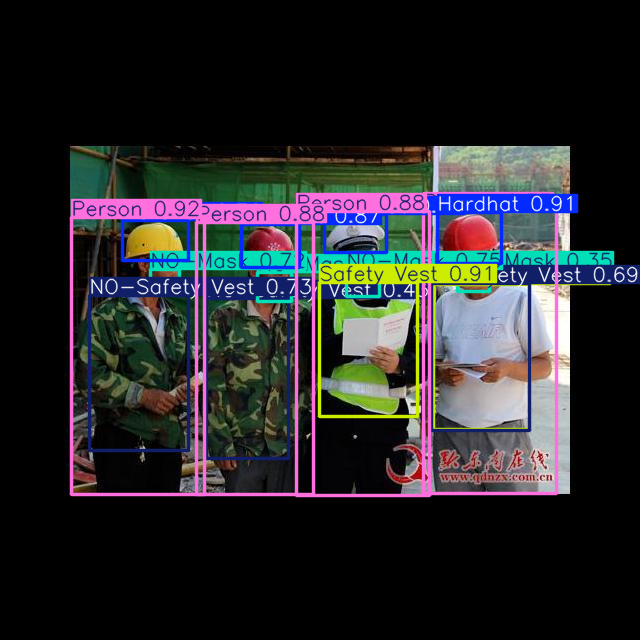

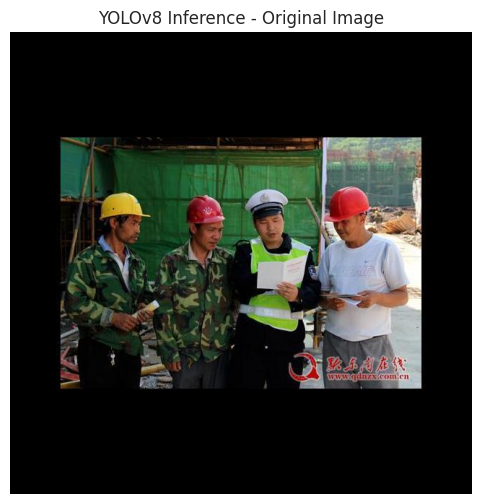

In [63]:
from PIL import Image
import matplotlib.pyplot as plt

# Path to test image
image_path = "../input/ppe-kit-detection-construction-site-workers/data/images/train/image100.jpg"

# Perform inference
results = model.predict(source=image_path, conf=0.25, show_labels=True, show_conf=True)

# Visualize predictions (uses OpenCV by default)
results[0].show()

# Optionally, you can save and view with matplotlib
img = Image.open(image_path)
plt.figure(figsize=(10, 6))
plt.imshow(img)
plt.title("YOLOv8 Inference - Original Image")
plt.axis("off")
plt.show()
